# Ensemble Method

In this notebook, we implement model averaging techniques, simple average and weighted average, to construct two ensemble methods from the four LSTM networks trained previously.

## Setup

As usual, this is the exact same setup process as found in all other nonlinear notebooks within this repository.

Import dependencies

In [1]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from Functions import tsPlot
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from skopt import gp_minimize
from tqdm import tqdm  # for progress bar
from IPython.display import clear_output, display

from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

Enable GPU

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

Import raw data

In [3]:
# Read the csv file into a pandas DataFrame
df_ret = pd.read_csv('../DataManagement/daily_data.csv', parse_dates=['DATE'], index_col='DATE')

# Drop everything except the columns we need for this scenario
df_ret = df_ret.filter(['DATE', 'NVDA_OPEN', 'NVDA_HIGH', 'NVDA_LOW', 'NVDA_CLOSE', 'NVDA_VOLUME'])

Generate technical indicators

In [4]:
# Calculate Simple Moving Averages (SMA)
df_ret['SMA_20'] = SMAIndicator(df_ret['NVDA_CLOSE'], window=20).sma_indicator()
df_ret['SMA_50'] = SMAIndicator(df_ret['NVDA_CLOSE'], window=50).sma_indicator()

# Calculate Exponential Moving Averages (EMA)
df_ret['EMA_20'] = EMAIndicator(df_ret['NVDA_CLOSE'], window=20).ema_indicator()
df_ret['EMA_50'] = EMAIndicator(df_ret['NVDA_CLOSE'], window=50).ema_indicator()

# Calculate Relative Strength Index (RSI)
df_ret['RSI'] = RSIIndicator(df_ret['NVDA_CLOSE']).rsi()

# Calculate Moving Average Convergence Divergence (MACD)
macd = MACD(df_ret['NVDA_CLOSE'])
df_ret['MACD'] = macd.macd()
df_ret['MACD_signal'] = macd.macd_signal()

# Calculate Bollinger Bands (BB)
bollinger = BollingerBands(df_ret['NVDA_CLOSE'])
df_ret['BB_upper'] = bollinger.bollinger_hband()
df_ret['BB_middle'] = bollinger.bollinger_mavg()
df_ret['BB_lower'] = bollinger.bollinger_lband()

# Specify the date range
start_date = '2018-06-30'
end_date = '2023-06-30'

# Slice the DataFrame for the desired date range
df_ret = df_ret.loc[start_date:end_date].copy()

Define function for creating sequences

In [5]:
def prepare_data_lstm(data, n_steps, column):
    column_names = [column]
    data = dc(data)  # make deep copy of the input data

    for i in range(1, n_steps+1):
        column_name = f'{column}(t-{i})'
        column_names.append(column_name)
        data[column_name] = data[column].shift(i)

    data.dropna(inplace=True)
    data = data.loc[:, data.columns.intersection(column_names)]

    return data

Create all data sequences

In [6]:
lookback = 7

timeseries_columns = ['NVDA_CLOSE', 'NVDA_OPEN', 'NVDA_HIGH', 'NVDA_LOW', 'NVDA_VOLUME']
indicator_columns = ['SMA_20', 'SMA_50', 'EMA_20', 'EMA_50', 'RSI', 'MACD', 'MACD_signal', 'BB_upper', 'BB_middle', 'BB_lower']

# Same as the univariate case
shifted_close = prepare_data_lstm(df_ret, lookback, 'NVDA_CLOSE')    

# New: now we also perform the same procedure on each of the additional features that we wish to include in our X matrix
shifted_open = prepare_data_lstm(df_ret, lookback, 'NVDA_OPEN')
shifted_high = prepare_data_lstm(df_ret, lookback, 'NVDA_HIGH')
shifted_low = prepare_data_lstm(df_ret, lookback, 'NVDA_LOW')
shifted_volume = prepare_data_lstm(df_ret, lookback, 'NVDA_VOLUME')

# Then the same process for all of the technical indicators we want to include in our X matrix
shifted_SMA20 = prepare_data_lstm(df_ret, lookback, 'SMA_20')
shifted_SMA50 = prepare_data_lstm(df_ret, lookback, 'SMA_50')
shifted_EMA20 = prepare_data_lstm(df_ret, lookback, 'EMA_20')
shifted_EMA50 = prepare_data_lstm(df_ret, lookback, 'EMA_50')
shifted_RSI = prepare_data_lstm(df_ret, lookback, 'RSI')
shifted_MACD = prepare_data_lstm(df_ret, lookback, 'MACD')
shifted_MACD_SIGNAL = prepare_data_lstm(df_ret, lookback, 'MACD_signal')
shifted_BB_UPPER = prepare_data_lstm(df_ret, lookback, 'BB_upper')
shifted_BB_MIDDLE = prepare_data_lstm(df_ret, lookback, 'BB_middle')
shifted_BB_LOWER = prepare_data_lstm(df_ret, lookback, 'BB_lower')

# Now we convert the dataframes into numpy matrices
shifted_close_np = shifted_close.to_numpy()
shifted_open_np = shifted_open.to_numpy()
shifted_high_np = shifted_high.to_numpy()
shifted_low_np = shifted_low.to_numpy()
shifted_volume_np = shifted_volume.to_numpy()
shifted_SMA20_np = shifted_SMA20.to_numpy()
shifted_SMA50_np = shifted_SMA50.to_numpy()
shifted_EMA20_np = shifted_EMA20.to_numpy()
shifted_EMA50_np = shifted_EMA50.to_numpy()
shifted_RSI_np = shifted_RSI.to_numpy()
shifted_MACD_np = shifted_MACD.to_numpy()
shifted_MACD_SIGNAL_np = shifted_MACD_SIGNAL.to_numpy()
shifted_BB_UPPER_np = shifted_BB_UPPER.to_numpy()
shifted_BB_MIDDLE_np = shifted_BB_MIDDLE.to_numpy()
shifted_BB_LOWER_np = shifted_BB_LOWER.to_numpy()

Perform scaling

In [7]:
price_scaler = MinMaxScaler(feature_range=(-1,1))    # Scaler for price data
volume_scaler = MinMaxScaler(feature_range=(-1,1))    # Scaler for volume data
indicator_scaler = StandardScaler()    # Scaler for indicators except MACD and MACD Signal
macd_scaler = StandardScaler()    # Scaler for MACD
macd_signal_scaler = StandardScaler()    # Scaler for MACD signal

# Scale the price data
shifted_open_np_scaled = price_scaler.fit_transform(shifted_open_np)
shifted_high_np_scaled = price_scaler.fit_transform(shifted_high_np)
shifted_low_np_scaled = price_scaler.fit_transform(shifted_low_np)
shifted_close_np_scaled = price_scaler.fit_transform(shifted_close_np)

# Scale the volume data
shifted_volume_np_scaled = volume_scaler.fit_transform(shifted_volume_np)

# Scale the indicators exc. MACD and MACD Signal
shifted_SMA20_np_scaled = indicator_scaler.fit_transform(shifted_SMA20_np)
shifted_SMA50_np_scaled = indicator_scaler.fit_transform(shifted_SMA50_np)
shifted_EMA20_np_scaled = indicator_scaler.fit_transform(shifted_EMA20_np)
shifted_EMA50_np_scaled = indicator_scaler.fit_transform(shifted_EMA50_np)
shifted_RSI_np_scaled = indicator_scaler.fit_transform(shifted_RSI_np)
shifted_BB_UPPER_np_scaled = indicator_scaler.fit_transform(shifted_BB_UPPER)
shifted_BB_MIDDLE_np_scaled = indicator_scaler.fit_transform(shifted_BB_MIDDLE)
shifted_BB_LOWER_np_scaled = indicator_scaler.fit_transform(shifted_BB_LOWER_np)

# Scale MACD
shifted_MACD_np_scaled = macd_scaler.fit_transform(shifted_MACD_np)

# Scale MACD Signal
shifted_MACD_SIGNAL_np_scaled = macd_signal_scaler.fit_transform(shifted_MACD_SIGNAL_np)

Form X and y matrices for each of the LSTM models that we will be working with. Specifically, the y vector will be the same in every case but we will have different X matrices (X_small, X_medium, X_large, X_final) since each of the LSTM models were trained and built to accept to accept different types of input data.

In [8]:
# Our y vector does not change in the multivariate case since we are still predicting the close prices
y = shifted_close_np_scaled[:, 0]

# Our X matrix does change though as we need to add additional dimensions to store the extra variables
# We start by slicing out the time t column from each of the X components
X_close = shifted_close_np_scaled[:, 1:]
X_open = shifted_open_np_scaled[:, 1:]
X_high = shifted_high_np_scaled[:, 1:]
X_low = shifted_low_np_scaled[:, 1:]
X_volume = shifted_volume_np_scaled[:, 1:]

X_SMA20 = shifted_SMA20_np_scaled[:, 1:]
X_SMA50 = shifted_SMA50_np_scaled[:, 1:]
X_EMA20 = shifted_EMA20_np_scaled[:, 1:]
X_EMA50 = shifted_EMA50_np_scaled[:, 1:]
X_RSI = shifted_RSI_np_scaled[:, 1:]
X_BB_UPPER = shifted_BB_UPPER_np_scaled[:, 1:]
X_BB_MIDDLE = shifted_BB_MIDDLE_np_scaled[:, 1:]
X_BB_LOWER = shifted_BB_LOWER_np_scaled[:, 1:]
X_MACD = shifted_MACD_np_scaled[:, 1:]
X_MACD_SIGNAL = shifted_MACD_SIGNAL_np_scaled[:, 1:]

# Then we individually "flip" each X component so that it goes, for example, t-7, t-6, t-5....
X_close = dc(np.flip(X_close, axis=1))
X_open = dc(np.flip(X_open, axis=1))
X_high = dc(np.flip(X_high, axis=1))
X_low = dc(np.flip(X_low, axis=1))
X_volume = dc(np.flip(X_volume, axis=1))

X_SMA20 = dc(np.flip(X_SMA20, axis=1))
X_SMA50 = dc(np.flip(X_SMA50, axis=1))
X_EMA20 = dc(np.flip(X_EMA20, axis=1))
X_EMA50 = dc(np.flip(X_EMA50, axis=1))
X_RSI = dc(np.flip(X_RSI, axis=1))
X_BB_UPPER = dc(np.flip(X_BB_UPPER, axis=1))
X_BB_MIDDLE = dc(np.flip(X_BB_MIDDLE, axis=1))
X_BB_LOWER = dc(np.flip(X_BB_LOWER, axis=1))
X_MACD = dc(np.flip(X_MACD, axis=1))
X_MACD_SIGNAL = dc(np.flip(X_MACD_SIGNAL, axis=1))

# Finally, we combine each X component into a single X matrix with the shape (samples, time steps, features) i.e. (1251, 7, 4) in this case
X_small = np.stack((
    X_close, 
    # X_open, 
    # X_high, 
    # X_low, 
    # X_volume,
    # X_SMA20,
    # X_SMA50,
    # X_EMA20,
    # X_EMA50,
    # X_RSI,
    # X_BB_UPPER,
    # X_BB_MIDDLE,
    # X_BB_LOWER,
    # X_MACD,
    # X_MACD_SIGNAL
    ), axis=-1)

X_medium = np.stack((
    X_close, 
    X_open, 
    X_high, 
    X_low, 
    X_volume,
    # X_SMA20,
    # X_SMA50,
    # X_EMA20,
    # X_EMA50,
    # X_RSI,
    # X_BB_UPPER,
    # X_BB_MIDDLE,
    # X_BB_LOWER,
    # X_MACD,
    # X_MACD_SIGNAL
    ), axis=-1)

X_large = np.stack((
    X_close, 
    X_open, 
    X_high, 
    X_low, 
    X_volume,
    X_SMA20,
    X_SMA50,
    X_EMA20,
    X_EMA50,
    X_RSI,
    X_BB_UPPER,
    X_BB_MIDDLE,
    X_BB_LOWER,
    X_MACD,
    X_MACD_SIGNAL
    ), axis=-1)

X_final = np.stack((
    X_close, 
    X_open, 
    X_high, 
    X_low, 
    # X_volume,
    X_SMA20,
    X_SMA50,
    X_EMA20,
    X_EMA50,
    X_RSI,
    X_BB_UPPER,
    X_BB_MIDDLE,
    # X_BB_LOWER,
    X_MACD,
    # X_MACD_SIGNAL
    ), axis=-1)

# Also, y currently has shape (1251) but it needs to have shape (1251, 1) in this framework
y = y.reshape((-1, 1))

Now split out the "unseen" test data.

In [9]:
# Define the split proportions first
train_ratio = 0.80  # 80% of data for training
valid_ratio = 0.15  # 15% of data for validation
test_ratio = 0.05   # 5% of data for testing


# First split: separate out the test set
train_valid_index = int(len(X_small) * (train_ratio + valid_ratio))

y_train_valid, y_test = y[:train_valid_index], y[train_valid_index:]

X_small_train_valid, X_small_test = X_small[:train_valid_index], X_small[train_valid_index:]
X_medium_train_valid, X_medium_test = X_medium[:train_valid_index], X_medium[train_valid_index:]
X_large_train_valid, X_large_test = X_large[:train_valid_index], X_large[train_valid_index:]
X_final_train_valid, X_final_test = X_final[:train_valid_index], X_final[train_valid_index:]


# Second split: separate out the validation set from the remaining data
train_index = int(len(X_small_train_valid) * train_ratio / (train_ratio + valid_ratio))

y_valid = y_train_valid[train_index:]

X_small_valid = X_small_train_valid[train_index:]
X_medium_valid = X_medium_train_valid[train_index:]
X_large_valid = X_large_train_valid[train_index:]
X_final_valid = X_final_train_valid[train_index:]

Now convert the numpy matrices into tensor objects.

In [10]:
y_test = torch.tensor(y_test).float()

X_small_test = torch.tensor(X_small_test).float()
X_medium_test = torch.tensor(X_medium_test).float()
X_large_test = torch.tensor(X_large_test).float()
X_final_test = torch.tensor(X_final_test).float()

y_valid = torch.tensor(y_valid).float()

X_small_valid = torch.tensor(X_small_valid).float()
X_medium_valid = torch.tensor(X_medium_valid).float()
X_large_valid = torch.tensor(X_large_valid).float()
X_final_valid = torch.tensor(X_final_valid).float()

Now generate dataset objects.

In [11]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
small_test_dataset = TimeSeriesDataset(X_small_test, y_test)
medium_test_dataset = TimeSeriesDataset(X_medium_test, y_test)
large_test_dataset = TimeSeriesDataset(X_large_test, y_test)
final_test_dataset = TimeSeriesDataset(X_final_test, y_test)

small_valid_dataset = TimeSeriesDataset(X_small_valid, y_test)
medium_valid_dataset = TimeSeriesDataset(X_medium_valid, y_test)
large_valid_dataset = TimeSeriesDataset(X_large_valid, y_test)
final_valid_dataset = TimeSeriesDataset(X_final_valid, y_test)

Now wrap the datasets in data loaders.

In [12]:
batch_size = 16

small_test_loader = DataLoader(small_test_dataset, batch_size=batch_size, shuffle=False)
medium_test_loader = DataLoader(medium_test_dataset, batch_size=batch_size, shuffle=False)
large_test_loader = DataLoader(large_test_dataset, batch_size=batch_size, shuffle=False)
final_test_loader = DataLoader(final_test_dataset, batch_size=batch_size, shuffle=False)

## Load the Trained LSTM Models

First we need to define the custom LSTM class as we have done before.

In [13]:
# Define custom LSTM class (same as before)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True, dropout=dropout)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

Next, we define the file paths to each of the trained LSTM models that we wish to load in.

In [14]:
model_small_path = "../Models/SmallLSTM/29-08-2023_18-30-14/SmallLSTM.pth"
model_medium_path = "../Models/MediumLSTM/29-08-2023_18-16-56/MediumLSTM.pth"
model_large_path = "../Models/LargeLSTM/29-08-2023_18-19-16/LargeLSTM.pth"
model_final_path = "../Models/FinalLSTM/29-08-2023_18-26-56/FinalLSTM.pth"

Then, we load in each of our trained LSTM models that we will be working with.

In [15]:
# Initialise the models
model_small = LSTM(input_size=1, hidden_size=4, num_stacked_layers=1, dropout=0.0)
model_small.to(device)

model_medium = LSTM(input_size=5, hidden_size=59, num_stacked_layers=1, dropout=0.21)
model_medium.to(device)

model_large = LSTM(input_size=15, hidden_size=81, num_stacked_layers=1, dropout=0.47)
model_large.to(device)

model_final = LSTM(input_size=12, hidden_size=128, num_stacked_layers=2, dropout=0.0)
model_final.to(device)

# Load the saved models
model_small.load_state_dict(torch.load(model_small_path))

model_medium.load_state_dict(torch.load(model_medium_path))

model_large.load_state_dict(torch.load(model_large_path))

model_final.load_state_dict(torch.load(model_final_path))

c:\Users\hello\anaconda3\envs\tensorflow\lib\site-packages\torch\nn\modules\rnn.py:70: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.21 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
c:\Users\hello\anaconda3\envs\tensorflow\lib\site-packages\torch\nn\modules\rnn.py:70: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.47 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


<All keys matched successfully>

Finally, we set all models to "eval" state so that we can use them for forecasting.

In [16]:
# Ensure the model is in evaluation mode
model_small.eval()
model_medium.eval()
model_large.eval()
model_final.eval()

LSTM(
  (lstm): LSTM(12, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

## Define the Ensemble

In [17]:
dates = df_ret.tail(len(X_small_test)).index

For a simple ensemble, we define a prediction function that simply averages the predictions of all the models.

In [18]:
def ensemble_simple_average_predict():
    # Small model predictions
    small_predictions = model_small(X_small_test.to(device)).detach().cpu().numpy().flatten()
    dummies = np.zeros((X_small_test.shape[0], lookback+1))
    dummies[:, 0] = small_predictions
    dummies = price_scaler.inverse_transform(dummies)

    small_predictions = dc(dummies[:, 0]) 

    # Medium model predictions
    medium_predictions = model_medium(X_medium_test.to(device)).detach().cpu().numpy().flatten()
    dummies = np.zeros((X_medium_test.shape[0], lookback+1))
    dummies[:, 0] = medium_predictions
    dummies = price_scaler.inverse_transform(dummies)

    medium_predictions = dc(dummies[:, 0]) 

    # Large model predictions
    large_predictions = model_large(X_large_test.to(device)).detach().cpu().numpy().flatten()
    dummies = np.zeros((X_large_test.shape[0], lookback+1))
    dummies[:, 0] = large_predictions
    dummies = price_scaler.inverse_transform(dummies)

    large_predictions = dc(dummies[:, 0]) 

    # Final model predictions
    final_predictions = model_final(X_final_test.to(device)).detach().cpu().numpy().flatten()
    dummies = np.zeros((X_final_test.shape[0], lookback+1))
    dummies[:, 0] = final_predictions
    dummies = price_scaler.inverse_transform(dummies)

    final_predictions = dc(dummies[:, 0]) 

    # Average all predicitons
    ensemble_predictions = np.mean([small_predictions, medium_predictions, large_predictions, final_predictions], axis=0)

    # y test values
    dummies = np.zeros((X_small_test.shape[0], lookback+1))
    dummies[:, 0] = y_test.flatten()
    dummies = price_scaler.inverse_transform(dummies)

    new_y_test = dc(dummies[:, 0])

    return ensemble_predictions, new_y_test


Next, we will define a more complex ensemble which introduces a weighted average where we assign different weights to each model based on their performance on the validation set.

The method we will use for calculating the weights is as follows:

1. Calculate RMSE metric for each model's predictions on the validation set
2. Inverse the RMSE metrics (so that models with lower RMWSE metrics (better performance) get higher weights)
3. Normalise the inverses so that the weights sum to 1

In [19]:
# Define function to generate the weights
def calculate_weights():
    # -- Generate predictions for each model on the validation set --
    
    # Small model predictions
    small_predictions = model_small(X_small_valid.to(device)).detach().cpu().numpy().flatten()
    dummies = np.zeros((X_small_valid.shape[0], lookback+1))
    dummies[:, 0] = small_predictions
    dummies = price_scaler.inverse_transform(dummies)

    small_predictions = dc(dummies[:, 0]) 

    # Medium model predictions
    medium_predictions = model_medium(X_medium_valid.to(device)).detach().cpu().numpy().flatten()
    dummies = np.zeros((X_medium_valid.shape[0], lookback+1))
    dummies[:, 0] = medium_predictions
    dummies = price_scaler.inverse_transform(dummies)

    medium_predictions = dc(dummies[:, 0]) 

    # Large model predictions
    large_predictions = model_large(X_large_valid.to(device)).detach().cpu().numpy().flatten()
    dummies = np.zeros((X_large_valid.shape[0], lookback+1))
    dummies[:, 0] = large_predictions
    dummies = price_scaler.inverse_transform(dummies)

    large_predictions = dc(dummies[:, 0]) 

    # Final model predictions
    final_predictions = model_final(X_final_valid.to(device)).detach().cpu().numpy().flatten()
    dummies = np.zeros((X_final_valid.shape[0], lookback+1))
    dummies[:, 0] = final_predictions
    dummies = price_scaler.inverse_transform(dummies)

    final_predictions = dc(dummies[:, 0]) 

    # y validation values
    dummies = np.zeros((X_small_valid.shape[0], lookback+1))
    dummies[:, 0] = y_valid.flatten()
    dummies = price_scaler.inverse_transform(dummies)

    new_y_valid = dc(dummies[:, 0])

    # -- Calculate inverse rmse for each model on the validation set --
    inverse_rmse = []

    rmse_small = inverse_rmse.append(1.0 / np.sqrt(mean_squared_error(new_y_valid, small_predictions)))
    rmse_medium = inverse_rmse.append(1.0 / np.sqrt(mean_squared_error(new_y_valid, medium_predictions)))
    rmse_large = inverse_rmse.append(1.0 / np.sqrt(mean_squared_error(new_y_valid, large_predictions)))
    rmse_final = inverse_rmse.append(1.0 / np.sqrt(mean_squared_error(new_y_valid, final_predictions)))

    # -- Calculate weights for each model based on the performance metrics --
    total = sum(inverse_rmse)
    weights = [inv / total for inv in inverse_rmse]

    return weights


# Define function to generate ensemble predictions using the weights calculated above
def ensemble_weighted_average_predict(weights):
    # Small model predictions
    small_predictions = model_small(X_small_test.to(device)).detach().cpu().numpy().flatten()
    dummies = np.zeros((X_small_test.shape[0], lookback+1))
    dummies[:, 0] = small_predictions
    dummies = price_scaler.inverse_transform(dummies)

    small_predictions = dc(dummies[:, 0]) 

    # Medium model predictions
    medium_predictions = model_medium(X_medium_test.to(device)).detach().cpu().numpy().flatten()
    dummies = np.zeros((X_medium_test.shape[0], lookback+1))
    dummies[:, 0] = medium_predictions
    dummies = price_scaler.inverse_transform(dummies)

    medium_predictions = dc(dummies[:, 0]) 

    # Large model predictions
    large_predictions = model_large(X_large_test.to(device)).detach().cpu().numpy().flatten()
    dummies = np.zeros((X_large_test.shape[0], lookback+1))
    dummies[:, 0] = large_predictions
    dummies = price_scaler.inverse_transform(dummies)

    large_predictions = dc(dummies[:, 0]) 

    # Final model predictions
    final_predictions = model_final(X_final_test.to(device)).detach().cpu().numpy().flatten()
    dummies = np.zeros((X_final_test.shape[0], lookback+1))
    dummies[:, 0] = final_predictions
    dummies = price_scaler.inverse_transform(dummies)

    final_predictions = dc(dummies[:, 0]) 

    # Average all predicitons using defined weights
    ensemble_predictions = (weights[0] * small_predictions +
                            weights[1] * medium_predictions +
                            weights[2] * large_predictions +
                            weights[3] * final_predictions
    )

    # y test values
    dummies = np.zeros((X_small_test.shape[0], lookback+1))
    dummies[:, 0] = y_test.flatten()
    dummies = price_scaler.inverse_transform(dummies)

    new_y_test = dc(dummies[:, 0])

    return ensemble_predictions

## Make Predictions

In [20]:
# Generate simple average ensemble predictions
sa_ensemble_predictions, y_test = ensemble_simple_average_predict()

# Generate weighted average ensemble predictions
weights = calculate_weights()
wa_ensemble_predictions = ensemble_weighted_average_predict(weights)

In [21]:
print(weights)

[0.2263649153878055, 0.2848594118464731, 0.24302265711260543, 0.24575301565311608]


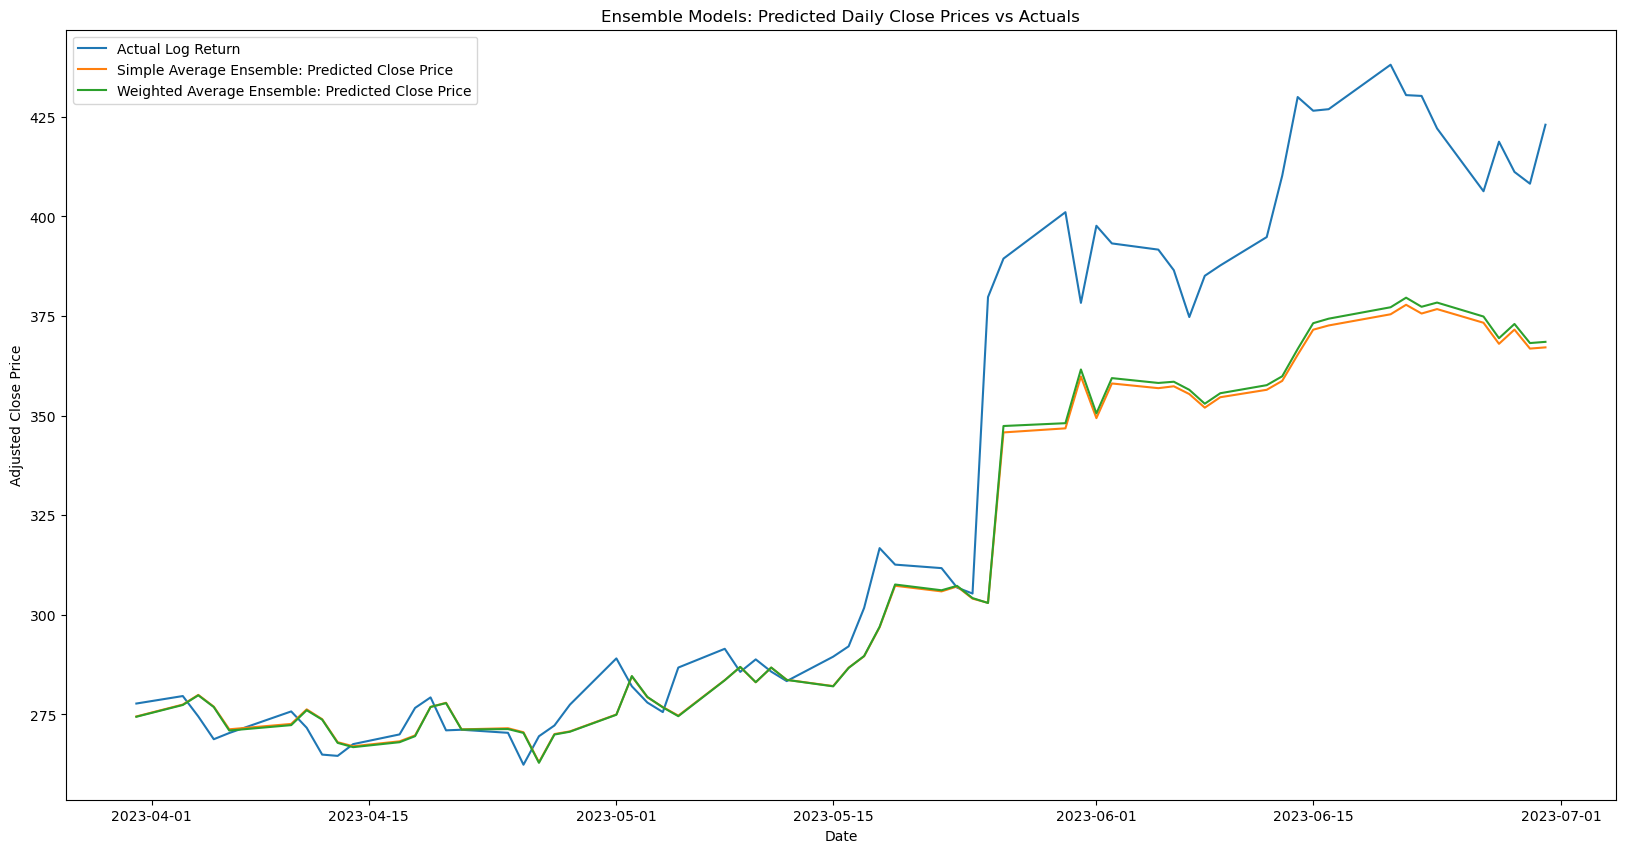

In [22]:
plt.figure(figsize=(20, 10))
plt.plot(dates, y_test, label='Actual Log Return')
plt.plot(dates, sa_ensemble_predictions, label='Simple Average Ensemble: Predicted Close Price')
plt.plot(dates, wa_ensemble_predictions, label='Weighted Average Ensemble: Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Ensemble Models: Predicted Daily Close Prices vs Actuals')
plt.legend()
plt.show()

## Analysis

**Win Rate:** Simply put, is the proportion of the time that the model simply predicted the correct "direction"

In [23]:
# Calculate the differences between consecutive elements
actual_diff = np.diff(y_test)
sa_predicted_diff = np.diff(sa_ensemble_predictions)
wa_predicted_diff = np.diff(wa_ensemble_predictions)

# Calculate the sign of the differences
actual_direction = np.sign(actual_diff)
sa_predicted_direction = np.sign(sa_predicted_diff)
wa_predicted_direction = np.sign(wa_predicted_diff)

# Calculate the number of correct predictions
sa_correct_predictions = np.sum(actual_direction == sa_predicted_direction)
wa_correct_predictions = np.sum(actual_direction == wa_predicted_direction)

# Calculate the win rate
sa_win_rate = sa_correct_predictions / len(actual_direction)
wa_win_rate = wa_correct_predictions / len(actual_direction)

print("Simple Average Ensemble Win Rate: {:.2f}%".format(sa_win_rate * 100))
print("Weighted Average Ensemble Win Rate: {:.2f}%".format(wa_win_rate * 100))


Simple Average Ensemble Win Rate: 56.45%
Weighted Average Ensemble Win Rate: 56.45%


**Root Mean Square Error (RMSE):** This metric tells you how close the predicted values are to the actual values. Lower values are better.

In [24]:
sa_rmse = np.sqrt(mean_squared_error(y_test, sa_ensemble_predictions))
wa_rmse = np.sqrt(mean_squared_error(y_test, wa_ensemble_predictions))

print(f'Simple Average Root Mean Square Error: {sa_rmse}')
print(f'Weighted Average Root Mean Square Error: {wa_rmse}')

Simple Average Root Mean Square Error: 30.072425499173832
Weighted Average Root Mean Square Error: 29.279309685514335


**Mean Absolute Error (MAE):** This metric is the average of the absolute differences between the predicted and actual values. It gives you an idea of how wrong your predictions were.

In [25]:
sa_mae = mean_absolute_error(y_test, sa_ensemble_predictions)
wa_mae = mean_absolute_error(y_test, wa_ensemble_predictions)

print(f'Simple Average Mean Absolute Error: {sa_mae}')
print(f'Weighted Average Mean Absolute Error: {wa_mae}')

Simple Average Mean Absolute Error: 20.850160846137953
Weighted Average Mean Absolute Error: 20.308663538998456


**Mean Absolute Percentage Error (MAPE):** This metric is similar to MAE, but it's expressed in relative terms. It's useful if you want to know the size of the prediction errors relative to the actual values.

In [26]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

sa_mape = mean_absolute_percentage_error(y_test, sa_ensemble_predictions)
wa_mape = mean_absolute_percentage_error(y_test, wa_ensemble_predictions)

print(f'Simple Average Mean Absolute Percentage Error: {sa_mape}%')
print(f'Weighted Average Mean Absolute Percentage Error: {wa_mape}%')

Simple Average Mean Absolute Percentage Error: 5.422776132808811%
Weighted Average Mean Absolute Percentage Error: 5.289658348020273%


**R2 Score (Coefficient of Determination):** This metric tells you how well your model fits the data. A score of 1 means the model perfectly predicts the actual values, and a score of 0 means the model does not predict the actual values at all.

In [27]:
sa_r2 = r2_score(y_test, sa_ensemble_predictions)
wa_r2 = r2_score(y_test, wa_ensemble_predictions)

print(f'Simple Average R2 Score: {sa_r2}')
print(f'Weighted Average R2 Score: {wa_r2}')

Simple Average R2 Score: 0.769171038948077
Weighted Average R2 Score: 0.7811860288768027


## Extra code: Generate Comparison Results

In this section, we simply generate results for the underlying models individually for the purpose of analysis and comparision in the written report.

### Model 1 (Small)

In [28]:
# Small model predictions
small_predictions = model_small(X_small_test.to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((X_small_test.shape[0], lookback+1))
dummies[:, 0] = small_predictions
dummies = price_scaler.inverse_transform(dummies)

small_predictions = dc(dummies[:, 0]) 

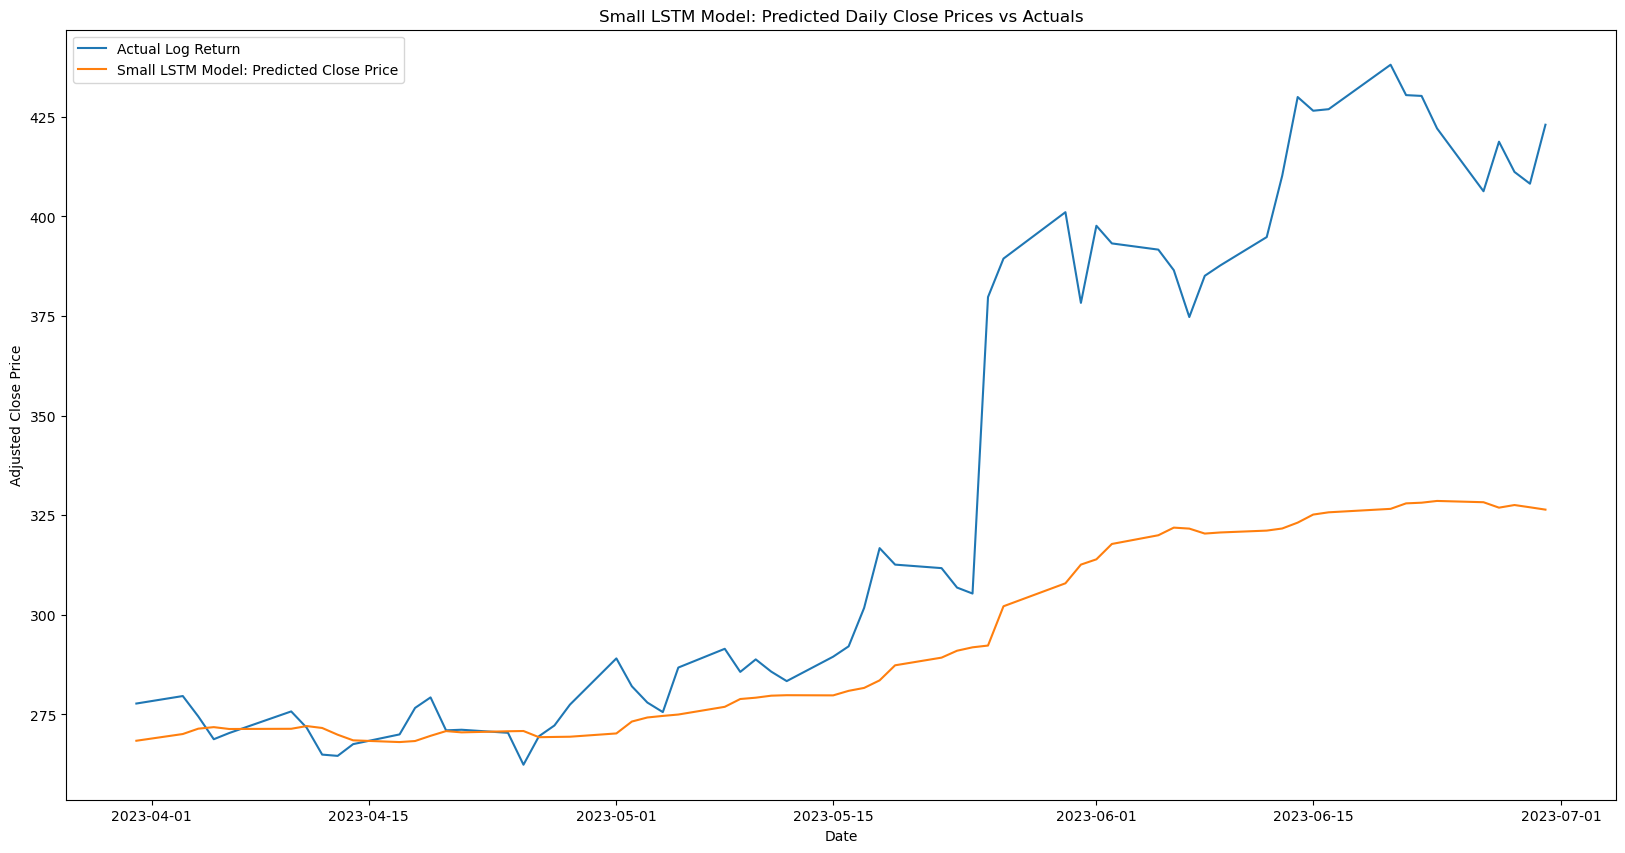

In [29]:
# Plot predictions of small model
plt.figure(figsize=(20, 10))
plt.plot(dates, y_test, label='Actual Log Return')
plt.plot(dates, small_predictions, label='Small LSTM Model: Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Small LSTM Model: Predicted Daily Close Prices vs Actuals')
plt.legend()
plt.show()

### Model 2 (Medium)

In [30]:
# Medium model predictions
medium_predictions = model_medium(X_medium_test.to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((X_medium_test.shape[0], lookback+1))
dummies[:, 0] = medium_predictions
dummies = price_scaler.inverse_transform(dummies)

medium_predictions = dc(dummies[:, 0]) 

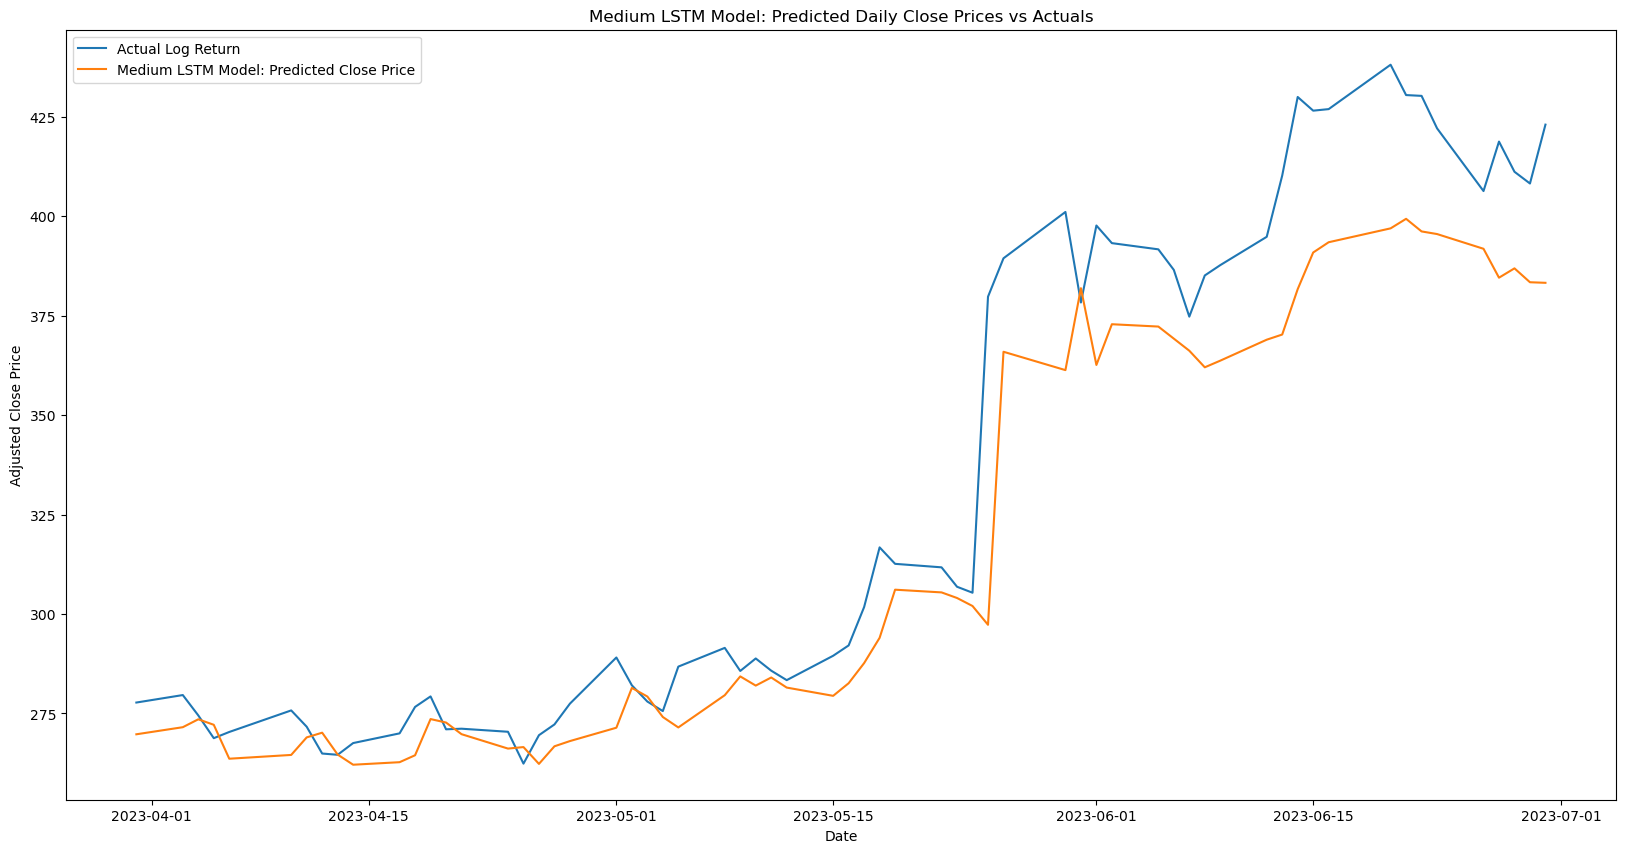

In [31]:
# Plot predictions of medium model
plt.figure(figsize=(20, 10))
plt.plot(dates, y_test, label='Actual Log Return')
plt.plot(dates, medium_predictions, label='Medium LSTM Model: Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Medium LSTM Model: Predicted Daily Close Prices vs Actuals')
plt.legend()
plt.show()

### Model 3 (Large)

In [32]:
# Large model predictions
large_predictions = model_large(X_large_test.to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((X_large_test.shape[0], lookback+1))
dummies[:, 0] = large_predictions
dummies = price_scaler.inverse_transform(dummies)

large_predictions = dc(dummies[:, 0]) 

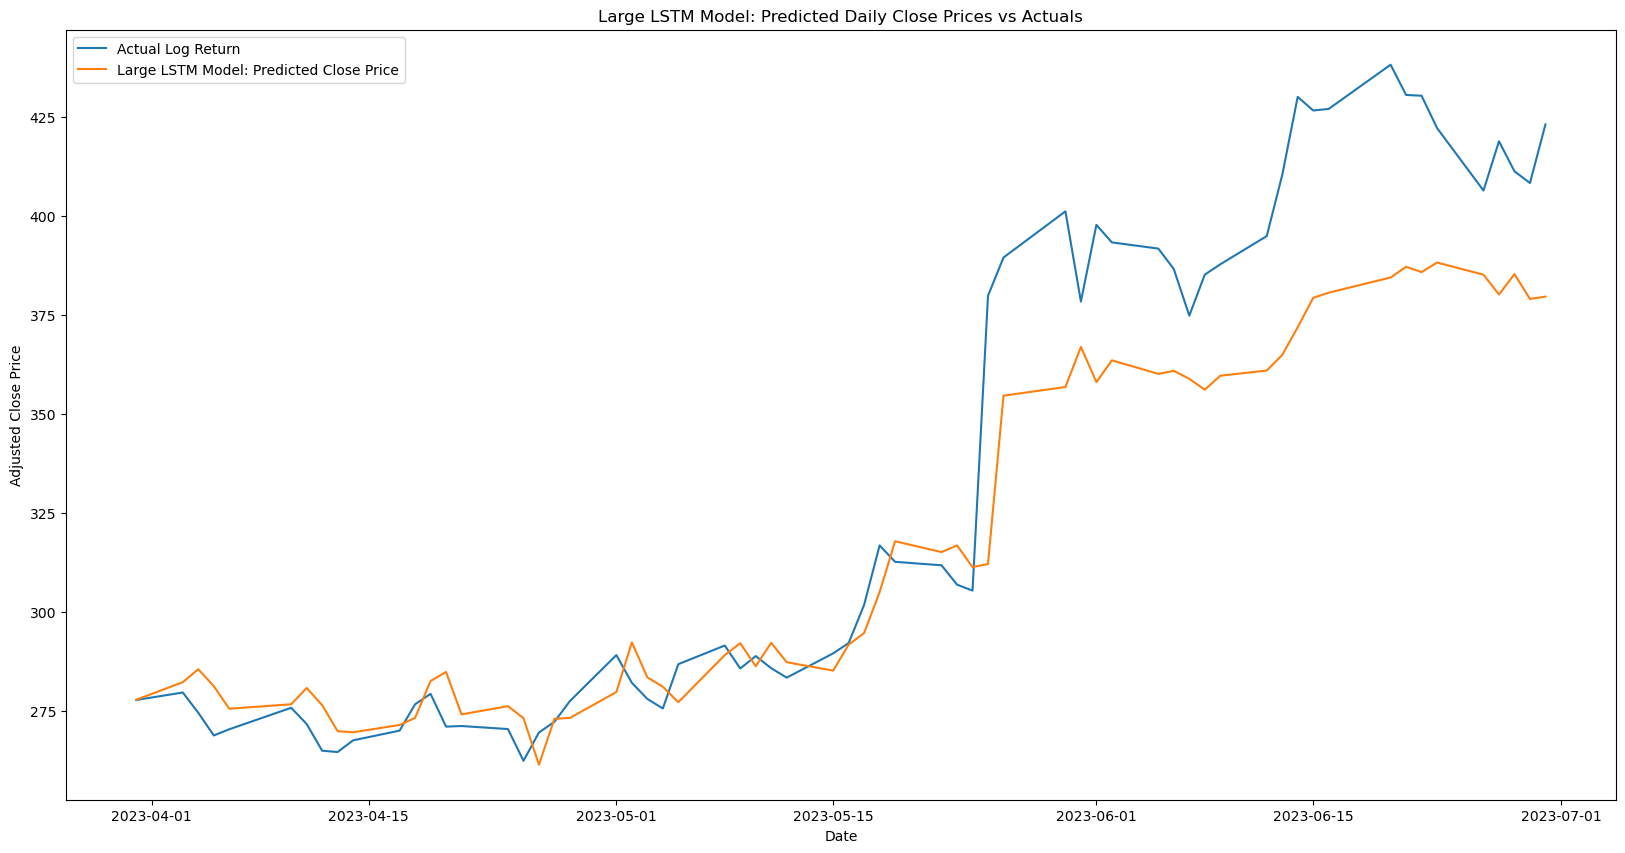

In [33]:
# Plot predictions of large model
plt.figure(figsize=(20, 10))
plt.plot(dates, y_test, label='Actual Log Return')
plt.plot(dates, large_predictions, label='Large LSTM Model: Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Large LSTM Model: Predicted Daily Close Prices vs Actuals')
plt.legend()
plt.show()

### Model 4 (Final)

In [34]:
# Final model predictions
final_predictions = model_final(X_final_test.to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((X_final_test.shape[0], lookback+1))
dummies[:, 0] = final_predictions
dummies = price_scaler.inverse_transform(dummies)

final_predictions = dc(dummies[:, 0]) 

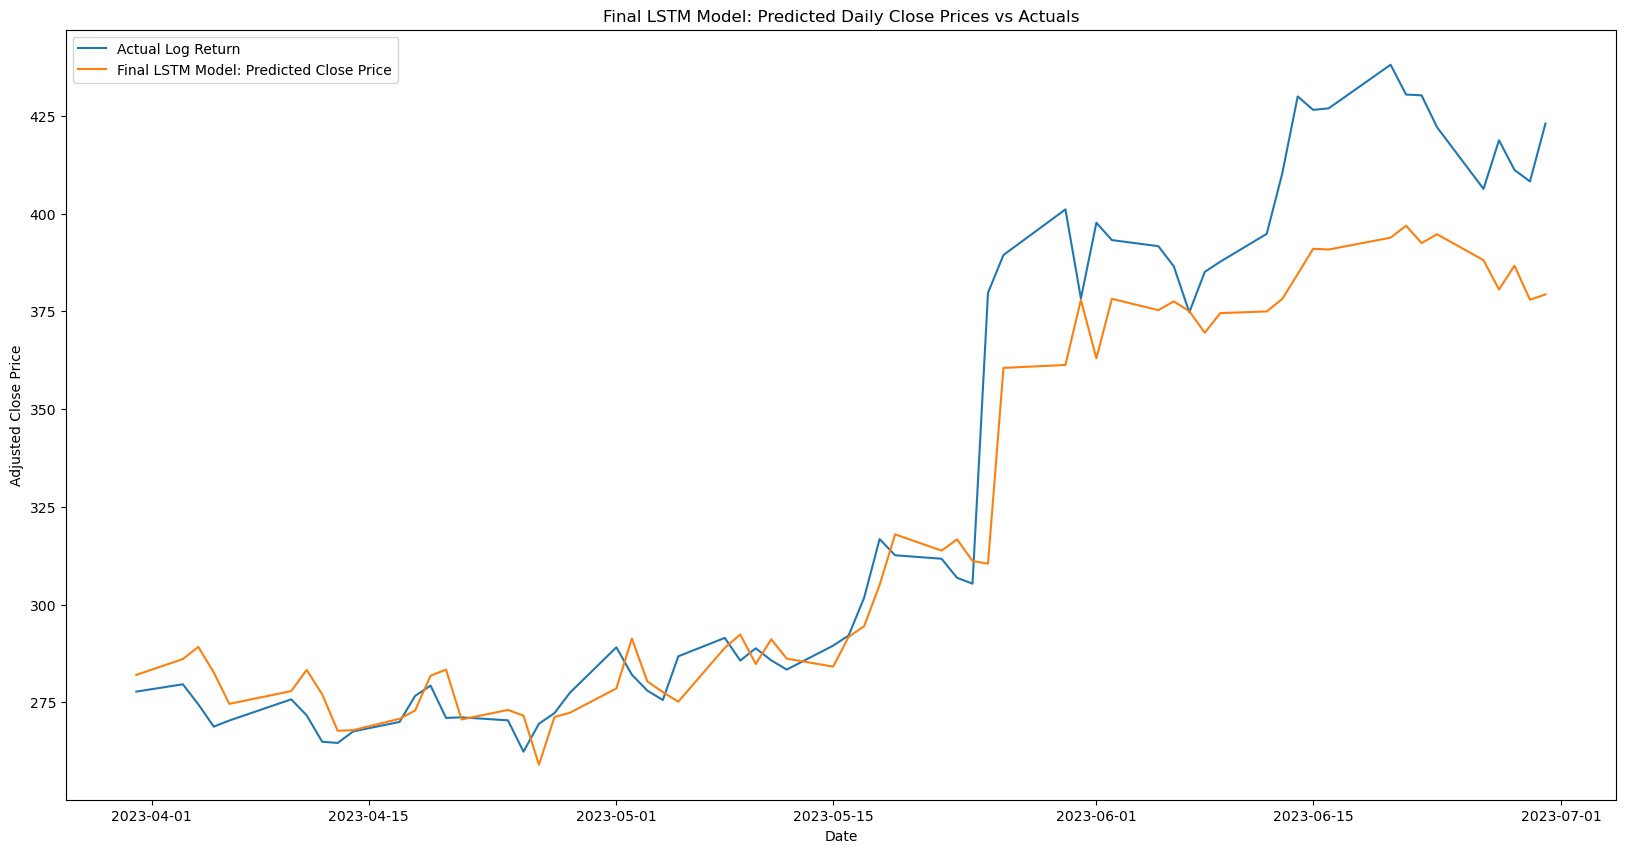

In [35]:
# Plot predictions of final model
plt.figure(figsize=(20, 10))
plt.plot(dates, y_test, label='Actual Log Return')
plt.plot(dates, final_predictions, label='Final LSTM Model: Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Final LSTM Model: Predicted Daily Close Prices vs Actuals')
plt.legend()
plt.show()

### All Models (Including both ensembles)

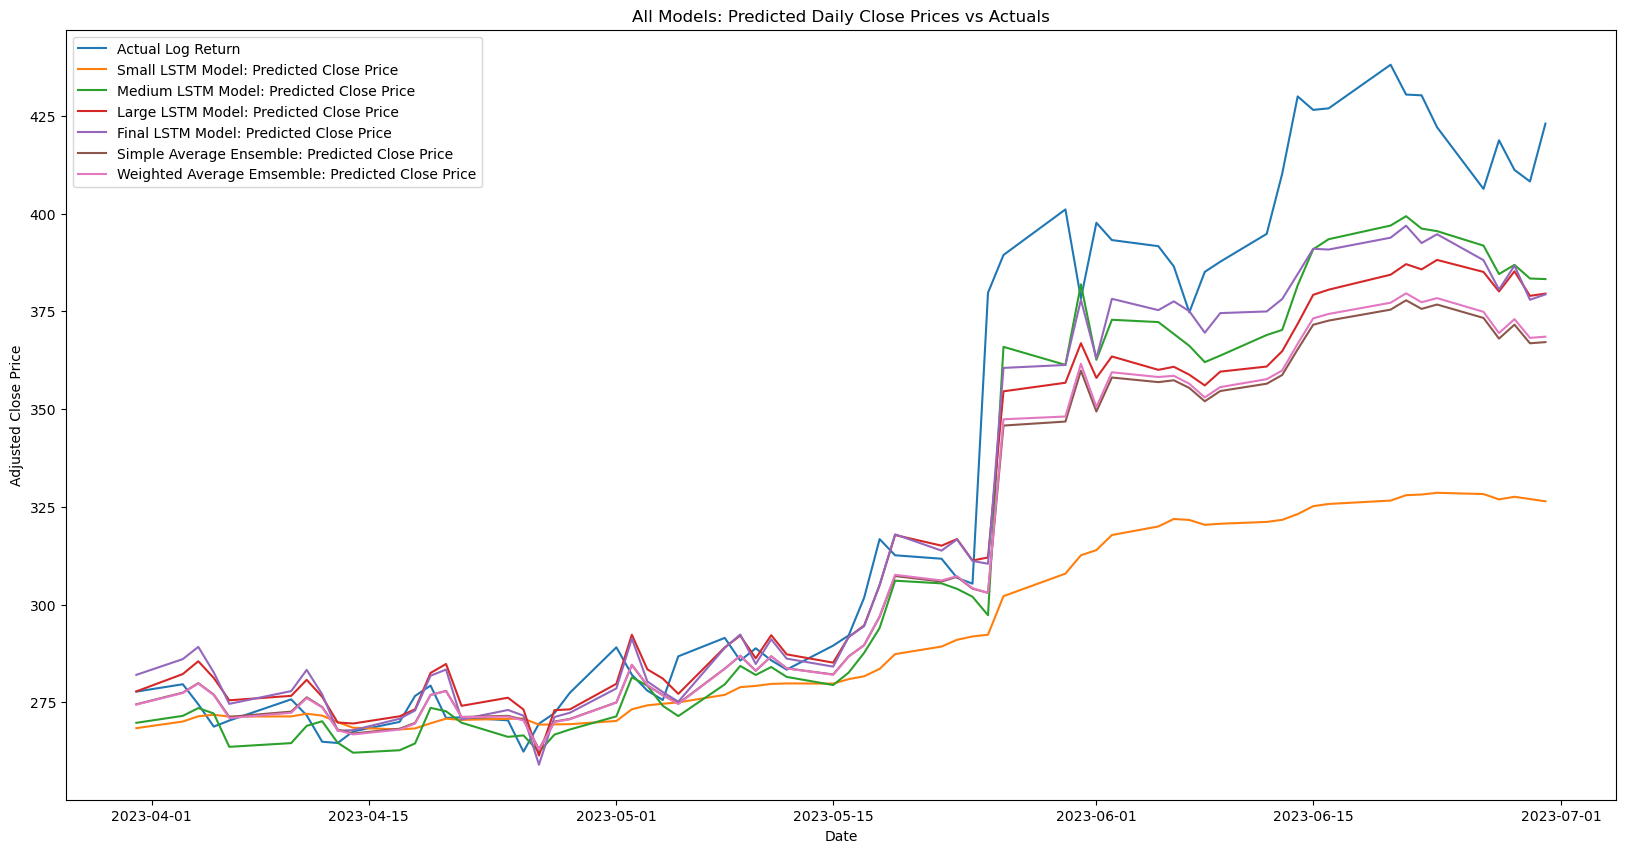

In [36]:
# Plot predictions of all models
plt.figure(figsize=(20, 10))
plt.plot(dates, y_test, label='Actual Log Return')

plt.plot(dates, small_predictions, label='Small LSTM Model: Predicted Close Price')
plt.plot(dates, medium_predictions, label='Medium LSTM Model: Predicted Close Price')
plt.plot(dates, large_predictions, label='Large LSTM Model: Predicted Close Price')
plt.plot(dates, final_predictions, label='Final LSTM Model: Predicted Close Price')

plt.plot(dates, sa_ensemble_predictions, label='Simple Average Ensemble: Predicted Close Price')
plt.plot(dates, wa_ensemble_predictions, label='Weighted Average Emsemble: Predicted Close Price')

plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('All Models: Predicted Daily Close Prices vs Actuals')
plt.legend()
plt.show()

### Performance Statistics

Win rate:

In [37]:
# Calculate the differences between consecutive elements
actual_diff = np.diff(y_test)
small_predicted_diff = np.diff(small_predictions)
medium_predicted_diff = np.diff(medium_predictions)
large_predicted_diff = np.diff(large_predictions)
final_predicted_diff = np.diff(final_predictions)

# Calculate the sign of the differences
actual_direction = np.sign(actual_diff)
small_predicted_direction = np.sign(small_predicted_diff)
medium_predicted_direction = np.sign(medium_predicted_diff)
large_predicted_direction = np.sign(large_predicted_diff)
final_predicted_direction = np.sign(final_predicted_diff)

# Calculate the number of correct predictions
small_correct_predictions = np.sum(actual_direction == small_predicted_direction)
medium_correct_predictions = np.sum(actual_direction == medium_predicted_direction)
large_correct_predictions = np.sum(actual_direction == large_predicted_direction)
final_correct_predictions = np.sum(actual_direction == final_predicted_direction)

# Calculate the win rate
small_win_rate = small_correct_predictions / len(actual_direction)
medium_win_rate = medium_correct_predictions / len(actual_direction)
large_win_rate = large_correct_predictions / len(actual_direction)
final_win_rate = final_correct_predictions / len(actual_direction)

RMSE:

In [38]:
small_rmse = np.sqrt(mean_squared_error(y_test, small_predictions))
medium_rmse = np.sqrt(mean_squared_error(y_test, medium_predictions))
large_rmse = np.sqrt(mean_squared_error(y_test, large_predictions))
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))

MAE:

In [39]:
small_mae = mean_absolute_error(y_test, small_predictions)
medium_mae = mean_absolute_error(y_test, medium_predictions)
large_mae = mean_absolute_error(y_test, large_predictions)
final_mae = mean_absolute_error(y_test, final_predictions)

MAPE:

In [40]:
small_mape = mean_absolute_percentage_error(y_test, small_predictions)
medium_mape = mean_absolute_percentage_error(y_test, medium_predictions)
large_mape = mean_absolute_percentage_error(y_test, large_predictions)
final_mape = mean_absolute_percentage_error(y_test, final_predictions)

R2:

In [41]:
small_r2 = r2_score(y_test, small_predictions)
medium_r2 = r2_score(y_test, medium_predictions)
large_r2 = r2_score(y_test, large_predictions)
final_r2 = r2_score(y_test, final_predictions)

Table:

In [42]:
# Initialise the variables (replace with actual values)
data = {
    'Model': ["Small", "Medium", "Large", "Final", "Simple average ensemble", "Weighted average ensemble"],
    'Win Rate': [small_win_rate, medium_win_rate, large_win_rate, final_win_rate, sa_win_rate, wa_win_rate],
    'RMSE': [small_rmse, medium_rmse, large_rmse, final_rmse, sa_rmse, wa_rmse],
    'MAE': [small_mae, medium_mae, large_mae, final_mae, sa_mae, wa_mae],
    'MAPE': [small_mape, medium_mape, large_mape, final_mape, sa_mape, wa_mape],
    'R2': [small_r2, medium_r2, large_r2, final_r2, sa_r2, wa_r2]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Function to color the max value in a Series green.
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

# Function to color the mmin value in a Series green.
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: green' if v else '' for v in is_min]

# Apply Styling
styled_df = df.style.apply(highlight_max, subset=['Win Rate', 'R2']).apply(highlight_min, subset=['RMSE', 'MAE', 'MAPE']).format({
    'Win Rate': "{:.2%}",
    'RMSE': "{:.2f}",
    'MAE': "{:.2f}",
    'MAPE': "{:.2f}",
    'R2': "{:.2f}"
}).hide_index().set_caption("Performance Metrics Across All Models").set_table_styles({
    'Model': [{'selector': 'td:hover',
               'props': [('font-size', '25px')]}],
    'Win Rate': [{'selector': 'td:hover',
                  'props': [('font-size', '25px')]}]
})

# Display the styled DataFrame
styled_df

Model,Win Rate,RMSE,MAE,MAPE,R2
Small,45.16%,55.12,38.84,10.02,0.22
Medium,58.06%,22.08,15.82,4.29,0.88
Large,58.06%,25.20,18.22,4.86,0.84
Final,56.45%,21.06,14.85,4.02,0.89
Simple average ensemble,56.45%,30.07,20.85,5.42,0.77
Weighted average ensemble,56.45%,29.28,20.31,5.29,0.78


Full analysis and interpretation of these results can be found in the full dissertation write-up.